In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
import copy
warnings.filterwarnings("ignore")
class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, period = None, pad = None, seasonal = 7):
        self.data = data
        self.window = window
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad
        if seasonal != 7:
            if seasonal % 2 == 0:
                raise ValueError("seasonal must be an odd positive integer >= 3")
        self.seasonal = seasonal

    def fit(self):
        
        dt = 1 / (self.period)
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = np.floor(len(t)/2)
        # Reflect f onto f on both tails
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)


        n = len(reflected)
        #Compute FFT
        fhat = np.fft.fft(reflected, n)
        fhat_seasonal = copy.copy(fhat)
        

        if self.window == "tukey":
            window = signal.tukey(len(reflected), alpha = self.pad)
        else:
            window = get_window(self.window, len(reflected))
        
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Apply window to freqs
        freq = freq*window

        # Filter freqs for trend (low pass filter from Celevaland 1990)
        filter_cutoff = 1.5*(1/self.seasonal)*(1/self.period)
             
        fhat[freq > filter_cutoff] = 0

        # Filter freqs for seasonal (high pass filter)
        fhat_seasonal[freq <= filter_cutoff] = 0

        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat)
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)

        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

In [67]:
import time

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
from statsmodels.tsa.tsatools import freq_to_period
warnings.filterwarnings("ignore")
class STF:


    # init method or constructor 
    def __init__(self, data, window, cutoff, period = None):
        self.data = data
        self.window = window
        self.cutoff = cutoff
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = 12 / period 

    def fit(self):
        
        dt = 1 / self.period
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)
      

        n = len(t)
        #Compute FFT
        fhat = np.fft.fft(f, n)
        fhat_seasonal = copy.copy(fhat)
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(f), alpha = self.pad) # We will need to be able to adjust the width of the windows, because we don't want the freq window to be dependent of the length of the TS alone
            # Add the alpha parameter to function as the seasonality parameter
        else:
            window = get_window(self.window, len(f)) 
    
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        freq = freq*window

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')

        plt.figure()
        plt.plot(freq[L], PSD[L])
        plt.show()


        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, self.cutoff))
        indices = PSD < peaks
        #indices = indices[int(half):(n + int(half))]
   
        # Zero out small Fourier coefs
        #fhat_clean = indices * fhat
        fhat[freq > 0.02] = 0
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat)

        # Filter out freqs with high power
        #indices_seasonal = PSD >= peaks
        #fhat_seasonal = indices_seasonal * fhat
        fhat_seasonal[freq <= 0.02] = 0
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        print("The dot product of STF seasonal and trend components is ", np.round(fhat_seasonal.dot(fhat)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

--- 0.08980226516723633 seconds ---
--- 0.08768081665039062 seconds ---


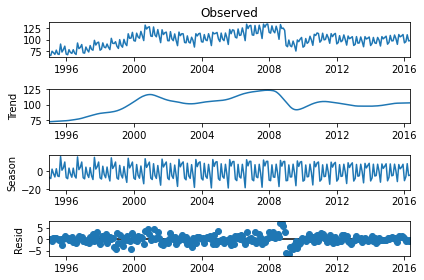

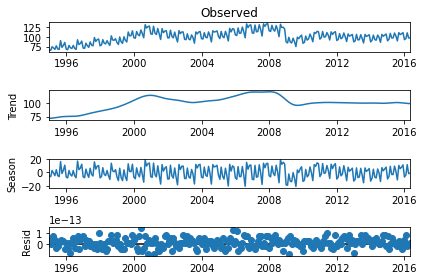

In [69]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds
import statsmodels.datasets

# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
start_time = time.time()
stl = STL(elec_equip, seasonal = 13)
res_robust = stl.fit()
fig = res_robust.plot()
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
stf = STF_reflected(elec_equip, "blackman", pad = 1, seasonal=13)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09879112243652344 seconds ---
--- 0.08945488929748535 seconds ---


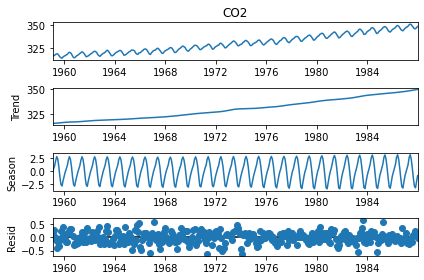

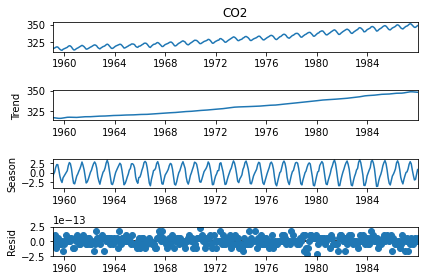

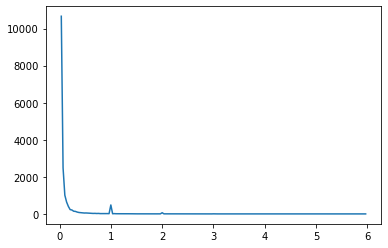

The dot product of STF seasonal and trend components is  -0j
The dot product of STF seasonal and trend components is  0j


12

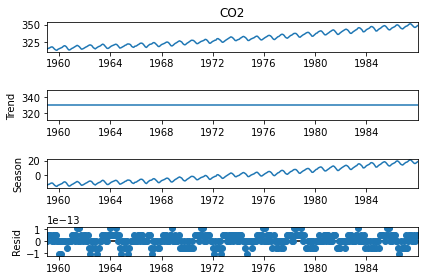

In [70]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)


start_time = time.time()
stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
stf = STF_reflected(co2, "blackman", pad = .5)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

stf = STF(co2, "boxcar", cutoff=.9)
res = stf.fit()
fig = res.plot()
stf.period

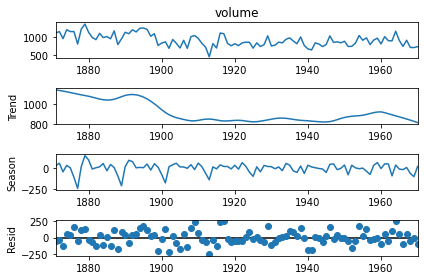

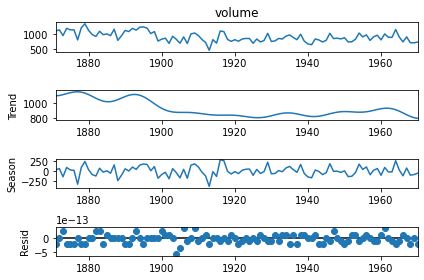

In [71]:
# Test stf vs stl on elec_equip data
data = statsmodels.datasets.nile.load().data

data.index = data["year"]
stl = STL(data["volume"], period = 12, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(data["volume"], window="blackman", period = 12)
res = stf.fit()
fig = res.plot()

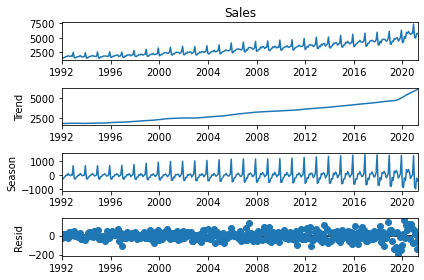

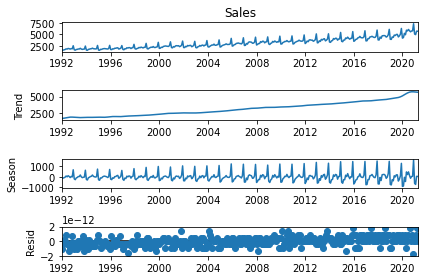

In [72]:
retail =pd.read_csv('../data/RetailSales.csv', index_col="DATE", parse_dates=True, squeeze=True)

stl = STL(retail)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(retail, "blackman", pad = .5)
res = stf.fit()
fig = res.plot()

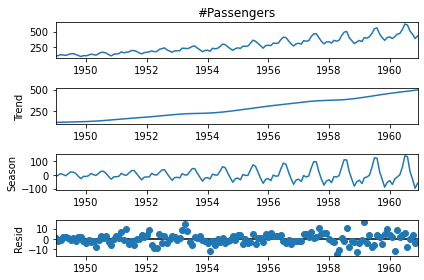

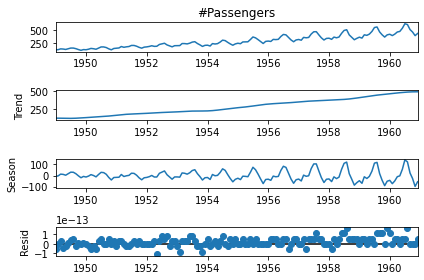

In [73]:
air = pd.read_csv('../data/AirPassengers.csv', index_col = "Month", parse_dates=True, squeeze=True)

stl = STL(air)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(air, "blackman", pad = .5)
res = stf.fit()
fig = res.plot()

--- 14.325071811676025 seconds ---
--- 0.12765121459960938 seconds ---


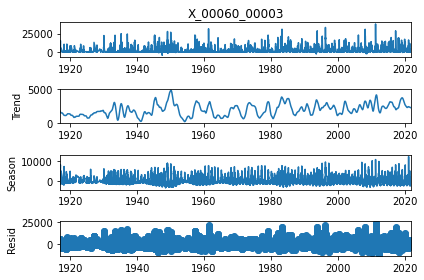

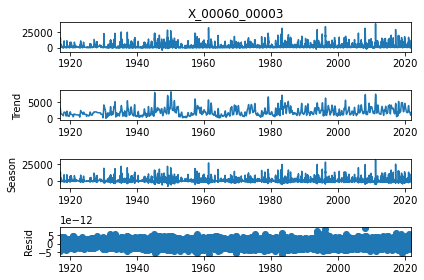

In [75]:
streamflow = pd.read_csv("../data/big_muddy_streamflow.csv", index_col="Date", parse_dates=True)

streamflow = streamflow["X_00060_00003"]
start_time = time.time()
stl = STL(streamflow, period = 365)
stl.fit().plot()
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()

stf = STF_reflected(streamflow, "blackman", pad = .5, period=365)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))